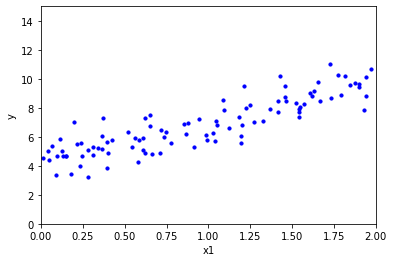

In [28]:
#Testing the Normal Equation (which gives us the model parameters which minimise the MSE performance measure)
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#Generate linear-looking data
np.random.seed(42)
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1) #Generate outputs with equation y = 4 + 3x + Gaussian noise

plt.scatter(X, y, s=10, c='b')
plt.xlabel('x1')
plt.ylabel('y')
plt.axis([0,2,0,15])
plt.show()

In [21]:
X_b = np.c_[np.ones((100,1)), X] #add x0=1 onto each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.21509616],
       [2.77011339]])

In [ ]:
#Can now make predictions using theta_best

In [25]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2,1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

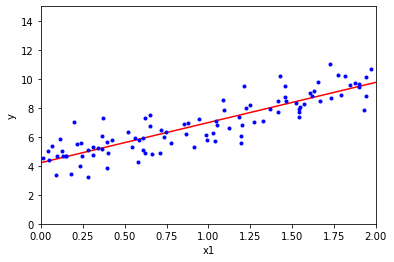

In [27]:
plt.plot(X_new, y_predict, 'r-')
plt.plot(X, y, 'b.')
plt.xlabel('x1')
plt.ylabel('y')
plt.axis([0,2,0,15])
plt.show()

In [29]:
#Linear regression with sklearn
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [30]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

In [32]:
#Equivalent to np.linalg.lstsq()
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

In [34]:
#Can find the pseudoinverse (Moore-Penrose inverse) directly. It is calculated using the matrix factorization technique
#Singular Value Decomposition (SVD). SVD is more efficient than finding the Normal Equation, and it handles edge cases
#nicely (i.e. the Normal Equation may not work if XTX is not invertible (singular), such as if m < n or if some features
#are redundant, but the pseudoinverse is always defined. 
#In terms of computational complexity, inverting XTX (which is of size n+1 x n+1) is typically O(2^2.4) to O(2^3) while SVD used by LinearRegression() is about O(n^2) - note both
#get very slow when the number of features is large (e.g. 100,000), meanwhile both are linear w.r.t. the number of training
#instances, O(m), so they handle large training sets efficiently (if they can fit in memory). Once the Linear Regression 
#model is trained, evaluations are fast as it is linear w.r.t. both the number of instances and the number of features.

np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

In [35]:
#Gradient descent: measure the local gradient of the error function with regard to the parameter vector theta, and 
#change theta in the direction of this descending gradient (theta is initialized with random values). The learning step
#size is proportional to the slope of the cost function, so the steps gradually decrease in size as the parameters 
#approach the minimum. The MSE cost function for a Linear Regression model happens to be a convex function, which means 
#that if you pick any two points on the curve, the line segment joining them never crosses the curve. This implies that 
#there are no local minima, just one global minimum. It is also a continuous function with a slope that never changes 
#abruptly, so GD is guaranteed to approach arbitrarily close to the global minimum (if the learning rate is not too high
#and with enough iterations.
#Interestingly, the cost function has the shape of a bowl, but this can be elongated if the features have very different
#scales - if it is elongated, it takes longer to reach the minimum since it may have to go in orthogonal directions to the
#optimal, depending on the local minimum. A perfect bowl shape means GD will go straight towards the minimum. This shows
#the importance of feature scaling e.g. using sklearns StandardScaler, or it takes much longer to converge.
#Further, since GD involves searching for a combination of model paramters in paramter space which minimizes the cost
#function, a higher dimensional parameters space means the search is harder. Fortunately, since the MSE cost function is
#convex in Linear Reegression, this has neglibible effect on GD in this simple case.

In [38]:
#Batch (or Full) Gradient Descent - the formula for the gradient of the cost function (MSE) w.r.t. all model parameters
#involves a matrix calculation over the full training set X, at each GD step. Hence, very slow for large training sets. 
#However, it scales well with the number of features - if there are 100,000s of features, a Linear Regression can be 
#trained much faster using GD over the Normal Equation or SVD. The key equation is theta(i+1) = theta(i) - eta*grad(MSE)

#Quick implementation:

eta = 0.1
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1) #random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta*gradients

theta #equivalent to solution from Normal Equation

array([[4.21509616],
       [2.77011339]])

In [39]:
#The learning rate is a crucial hyperparameter - too small and the algorithm takes a very long time to converge on the 
#solution, too high and the algorithm diverges, jumping all over the parameter space and potentially getting further from
#the solution with every step. 
#To find a good eta, use grid search, but limit the number of iterations so grid search can eliminate models that take
#too long to converge. To select the right number of iterations, a solution is to set a very large number and interrupt
#the algorithm when the gradient vector becomes tiny (when its norm is less than some tolerance epsilon), since this
#occurs when GD is close to the minimum.
#With respect to the convergence rate: when the cost function is convex and its slope does not change abruptly (as is the
#case for the MSE cost function), Batch Gradient Descent with a fixed learning rate will eventually converge to the 
#optimal solution, but you may have to wait a while: it can take O(1/ϵ) iterations to reach the optimum within a range 
#of ϵ, depending on the shape of the cost function. If you divide the tolerance by 10 to have a more precise
#solution, then the algorithm may have to run about 10 times longer.

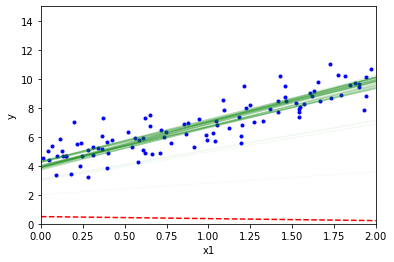

array([[4.21076011],
       [2.74856079]])

In [70]:
#Stochastic Gradient Descent - the algorithm picks a random instance in the training set at every step and computes the
#gradients based on this single instance (opposed to BGD, which uses the entire X to compute gradients each step). Hence,
#the algorithm is much faster as it has very ittle data to manipulate every iteration, also makes it possible to train
#on huge datasets since only one instance has to be in memory at each iteration (so can be used as an out-of-core algo).
#However, the stochastic nature menas the algorithm is less regular than BGD: instead of gently decreasing it only 
#decreases on average, generally bouncing up and down the cost function. It will get close to the optimal solution, but not
#exactly. 
#This stochasticism is useful with very irregular cost functions, as the algorithm can jump out of local minima, so in 
#these cases (not Linear Regression) SGD has a better chance than BGD of reaching the global minimum.
#A solution to the dilemma that it does not settle at the minimum is to gradually reduce the learning rate - steps are 
#large initially (so quick progress and escape local minima) but gradually becomes smaller, allowing it to settle at the
#global minimum (similar to simulated annealing). The learning schedule determines the learning rate at each iteration.

#SGD applied to linear regression:

n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

np.random.seed(42)
theta = np.random.randn(2,1) # random initialization

X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2,1)), X_new]
y_predict = X_new_b.dot(theta)

plt.plot(X, y, 'b.')
plt.xlabel('x1')
plt.ylabel('y')
plt.axis([0,2,0,15])
plt.plot(X_new, y_predict, 'r--')

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        if epoch == 0 and i < 20:
            X_new = np.array([[0], [2]])
            X_new_b = np.c_[np.ones((2,1)), X_new]
            y_predict = X_new_b.dot(theta)
            plt.plot(X_new, y_predict, 'g-', alpha=0.02*i)

plt.show()
theta

In [69]:
X_b[random_index], X_b[random_index:random_index+1]

(array([1.        , 1.20223002]), array([[1.        , 1.20223002]]))

In [ ]:
#Note that since instances are picked randomly, some instances may be picked several times per epoch, while others may 
#not be picked at all. If you want to be sure that the algorithm goes through every instance at each epoch, another 
#approach is to shuffle the training set (making sure to shuffle the input features and the labels jointly), then go 
#through it instance by instance, then shuffle it again, and so on. However, this approach generally converges more slowly.

#Also note, when using Stochastic Gradient Descent, the training instances must be independent and identically distributed 
#(IID) to ensure that the parameters get pulled toward the global optimum, on average. A simple way to ensure this is to 
#shuffle the instances during training (e.g., pick each instance randomly, or shuffle the training set at the beginning of 
#each epoch). If you do not shuffle the instances—for example, if the instances are sorted by label—then SGD will start 
#by optimizing for one label, then the next, and so on, and it will not settle close to the global minimum.

In [75]:
#Using sklearn for a SGD Linear Regressor
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel()) #y.ravel() converts y from a column vector to flattened 1D array, required for this function
sgd_reg.intercept_, sgd_reg.coef_

(array([4.16405639]), array([2.74807964]))

In [ ]:
#Mini-batch Gradient Descent - at each step, instead of computing the gradients using all training instances (BGD) or 
#just one instance (SGD), MBGD computes the gradients on small random sets of instances (mini-batches). The big
#advantage of mini-batch GD over SGD is that you can get a performance boost from (GPU) hardware optimization of matrix
#operations. Especially with larger batches, the algorithms progress in parameter space is less erratic that SGD, so
#MBGD it will likely get closer to the minimum compared to SGD but it may be harder for it to escape local minima (in the
#case of problems that suffer from local minima, unlike linear regression). With a good learning schedule, MBGD and SGD can
#can reach the optimal global minimum like BGD, while being more efficient than BGD per iteration (BGD is very slow).

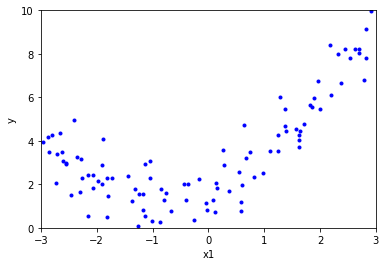

In [77]:
#Polynomial Regression - to fit non-linear data, we add powers of each feature as new features, then train a linear model
#on this extended set of features.

#Generate some data based on a simple quadratic equation
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

plt.plot(X, y, 'b.')
plt.axis([-3, 3, 0, 10])
plt.xlabel('x1'); plt.ylabel('y')
plt.show()

In [78]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0], X_poly[0] #X_poly contains each feature, plus the square of the feature

(array([-0.75275929]), array([-0.75275929,  0.56664654]))

In [79]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

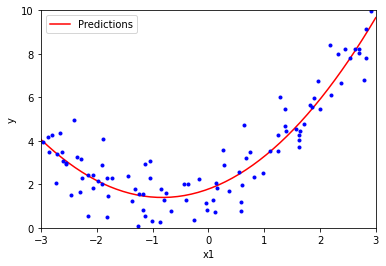

In [103]:
#1
x_range = list(zip(np.linspace(-3,3,50), np.linspace(-3,3,50)**2))
y_predict = lin_reg.predict(x_range)
plt.plot([x[0] for x in x_range], y_predict, 'r-', label='Predictions')

#2
#y_predict2 = lin_reg.coef_.dot(np.array([np.linspace(-3,3,50),np.linspace(-3,3,50)**2])) + lin_reg.intercept_
#plt.plot(np.linspace(-3,3,50), y_predict2.ravel(), 'r-', label='Predictions')

plt.plot(X, y, 'b.')
plt.axis([-3, 3, 0, 10])
plt.xlabel('x1'); plt.ylabel('y')
plt.legend()
plt.show()

In [ ]:
#Note that when there are multiple features, Polynomial Regression is capable of finding relationships between features 
#(which is something a plain Linear Regression model cannot do). This is made possible by the fact that PolynomialFeatures
#also adds all combinations of features up to the given degree. For example, if there were two features a and b, 
#PolynomialFeatures with degree=3 would not only add the features a2, a3, b2, and b3, but also the combinations 
#ab, a2b, and ab2.
#PolynomialFeatures(degree=d) transforms from n features to (n+d)! / d!n! features, so beware of combinatorial explosion
#of the number of features (also, overfitting etc., see next section)

In [115]:
#It is easy to see a 300 degree polynomial will fit the training data better, severely overfitting it, while a linear
#model will underfit it. A quadratic model will obviously generalize best out-of-sample, but in general we will not know 
#that this was how the data was generated. How do we decide how complex the model should be and if it is over/underfitting?
#Cross-validation can be used to check generalization performance: good performance on the training data and poor 
#generalization indicates overfitting, while poor performance in both scenarios suggests underfitting - allowing us to
#determine if a model is too simple or too complex.
#Another way it to look at learning curves: plots of the models performance on the training set and validation set as
#a function of the training set size (or the training iteration). To generate these, train the model several times on 
#different subsets of the training set.

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

#a function that, given some training data, plots the learning curves of the model
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='train')
    plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label='val')
    plt.ylabel('RMSE')
    plt.xlabel('Training set size')
    plt.legend()

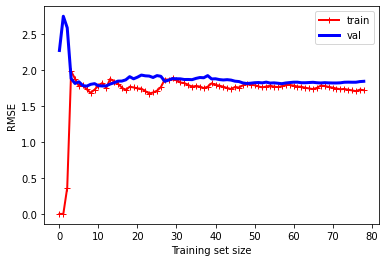

In [128]:
#This model that’s underfitting deserves a bit of explanation. First, let’s look at the performance on the training data: 
#when there are just one or two instances in the training set, the model can fit them perfectly, which is why the curve 
#starts at zero. But as new instances are added to the training set, it becomes impossible for the model to fit
#the training data perfectly, both because the data is noisy and because it is not linear at all. So the error on the
#training data goes up until it reaches a plateau, at which point adding new instances to the training set doesn’t make 
#the average error much better or worse. Now let’s look at the performance of the model on the validation data. When the 
#model is trained on very few training instances, it is incapable of generalizing properly, which is why the validation 
#error is initially quite big. Then, as the model is shown more training examples, it learns, and thus the validation error
#slowly goes down. However, once again a straight line cannot do a good job modeling the data, so the error ends up at 
#a plateau, very close to the other curve. These learning curves are typical of a model that’s underfitting. Both curves 
#have reached a plateau; they are close and fairly high.
#If a model is underfitting, adding more training examples will not help - you need to use a more complex model or create
#better features

lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

(0.0, 5.0)

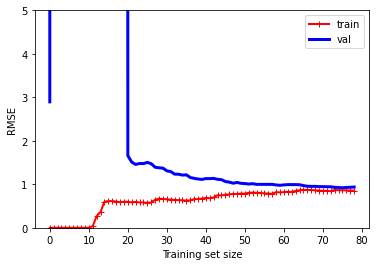

In [133]:
#Now for the learning curve of a 10th degree polynomial fitting (noisy) quadratic data. There are two key differences
#to the previous learning curve: (1) the error on the training data is much lower than the simpler Linear Regression model
#(2) there is a gap between the curves, meaning that the model performs significantly better on the training set than the
#validation set - the hallmark of overfitting. Using a much larger training set would mean that the curves would continue
#to get closer, since the ratio of the training data points to model complexity (/VC dimension) will become closer to 10, 
#the 'rule of thumb' for the recommended ratio. We can see that the curves do converge as the training set size increases.

from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression())
])

plot_learning_curves(polynomial_regression, X, y)
plt.ylim(0, 5)

In [134]:
#Regularization (i.e. constraining a model/reducing the number of degrees of freedom) makes it harder to overfit the data.
#Polynomial models are generally regualrized by reducing the number of polynomial degrees, while linear models are
#regularized by constraining the weights - three main ways are Ridge Regression, Lasso Regression, and Elastic Net

#Ridge regression (or Tikhonov regularization) is a regularized version of Linear Regression: a regularization term equal
#to (α/2)*Σθi^2, from i=1 to n, is added to the cost function. N.B. if w is the vector or feature weights (theta1 to thetan
#not including theta0), the regularization term is equal to (1/2)*||w||^2, half the square of the l2 norm of w). This 
#forces the algorithm to both fit the data and keep the model weights as small as possible (note the regularization term 
#is only added to the cost function during training). Alpha controls how much you want to regularize the model - if alpha
#is large, then all weights end up close to zero and we have a flat line through the data's mean, while alpha = 0 is just 
#Linear Regression. It is important to scale the data (e.g. using StandardScaler) before Ridge Regression, as like most
#regularized models it is sensitive to the scale of the input features. Note that scaling needs to be applied to all
#features, so if using PolynomialFeatures (i.e. transforming to a non-linear space) do scaling after the transformation.
#On polynomial models, higher alpha leads to flatter (less extreme, more reasonable) predictions, thus reducing the model's
#variance but increasing its bias.

#N.B. It is quite common for the cost function used during training to be different from the performance measure used 
#for testing. Apart from regularization, another reason they might be different is that a good training cost function 
#should have optimization-friendly derivatives, while the performance measure used for testing should be as close as 
#possible to the final objective. For example, classifiers are often trained using a cost function such as the log loss 
#(discussed in a moment) but evaluated using precision/recall.

#Like Linear Regression, we have the option of a closed-form solution and GD to perform Ridge Regression - the pros and 
#cons are the same. 

#Here is Ridge Regression using a closed-form solution (a variant that uses a matrix factorization technique by
#Cholesky).

from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1, solver='cholesky')
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[4.82497007]])

In [137]:
#or using SGD. Can alternatively use the Ridge class with the "sag" (Stochastic Average GD) solver - a variant of SGD.

sgd_reg = SGDRegressor(penalty='l2') #penalty hyperparameter sets the regularization term to use
sgd_reg.fit(X, y.ravel())

ridge_reg = Ridge(alpha=1, solver='sag')
ridge_reg.fit(X, y)

sgd_reg.predict([[1.5]]), ridge_reg.predict([[1.5]])

(array([4.77915875]), array([[4.80772685]]))

In [140]:
#Lasso Regression (Least Absolute Shrinkage and Selection Operator Regression) - it adds a regularization term to the cost
#function just like Ridge regression, except it uses the l1 norm of the weight vector instead of half the square of the l2
#norm: α*Σ|θi| from i=1 to n.
#An important characteristic of Lasso Regression is that it tends to eliminate the weights of the least important features
#(i.e. set them to zero). So in the case of polynomial regression, it is possible that the high-degree features are set to
#zero - Lasso Regression automatically performs feature selection and outputs a sparse model (with few nonzero weights).
#Ridge Regression is different in two ways: (1) the gradients get smaller as the parameters approach the global optimum,
#so GD naturally slows down, helping convergence. Lasso Regression bounces around because the l1 norm means the gradient
#doesnt get close to zero even at the minimum. (2)  the optimal weights of Ridge Regression get closer to zero when alpha 
#is increased, but unlike Lasso they never get eliminated entirely.
#N.B. to avoid GD bouncing around the optimum when using Lasso, you need to gradually reduce the learning rate during
#training (it will still bounce around, but the steps get smaller so it converges).

#Note that the Lasso cost function is not differentiable for any theta_i = 0 (i=1 to n), but GD still works fine if you
#use a subgradient vector instead when any theta_i = 0 (a subgradient vector at a nondifferentiable point is like an
#intermediate vector between the gradient vectors around that point). 
#Subgradient vector g(theta, J) = grad(MSE) + alpha*column_vector[sign(theta_i)]

#sklearn implementation of Lasso Regression; can also use SGDRegressor(penalty='l1')
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([4.77621741])

In [141]:
#Elastic Net is a middle ground between the two - the regularization term in a simple mix of each, controlled by the mix 
#ratio r. When r = 0, Elastic Net is equivalent to Ridge and when r = 1, it is equivalent to Lasso.
#Cost function J(theta) = MSE + r*α*Σ|θi| + (1-r)/2 * α*Σθi^2

#In general it is always good to have some regularization (i.e. avoid plain Linear Regression). Ridge is a good default, 
#but if you suspect that only a few features are useful, you should prefer Lasso or Elastic Net as they tend to reduce
#the useless features' weights down to zero. In general, Elastic Net is preferred to Lasso as Lasso may behave erratically
#when the number of features is greater than the number of training instances or when several features are strongly 
#correlated.

#sklearn implementation of Elastic Net
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([4.78114505])

In [ ]:
#A different way to regularize iterative learning algorithms such as GD is to stop training as soon as the validation
#error reaches a minimum - termed early stopping. 
#As the number of epochs increases, the algorithms (RMSE) prediction error on the training set will generally decrease 
#along with its prediction error on the validation set; however, after a while the validation set error may stop decreasing
#and begin to increase, suggesting overfitting of the training data. Early stopping stops training as soon as the 
#validation error reaches a minimum.
#The identification of this minimum can be difficult with SGD and MBGD as the curves are not so smooth. A solution is to
#stop only after the validation error has been above the minimum for some time (when you are confident the model will not
#do any better), then roll back the model parameters to the point where the validation error was at a minimum.

#Basic implementation of early stopping
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

#prepare the data
poly_scaler = Pipeline([
    ('poly_features', PolynomialFeatures(degree=90, include_bias=False)),
    ('std_scaler', StandardScaler())
])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

#warm_start=True means the model continues where it left off when fit is called again, rather than restarting from 
#scratch each epoch. Note SGDRegressor() has a parameter called early_stopping (see docs)
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                      penalty=None, learning_rate='constant', eta0=0.0005) 

minimum_val_error = float('inf')
best_epoch = None
best_model = None

for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

In [145]:
#Logistic Regression is used to estimate the probability that an instance belongs to a particular class - if the estimated
#probability is greater than 50%, then the model predicts that the instance belongs to that class (the positive class,
#labelled '1'), and otherwise predicts that it does not (i.e. that it belongs to the negative class, '0'). Hence it is a 
#binary classifier.
#Like Linear Regression, Logistic Regression computes the weighted sum of the input features (plus a bias), but instead of
#outputting the result directly it outputs the logistic of this result. The logistic, generally sigma, is a sigmoid 
#function that outputs a number between 0 and 1: sigma(t) = (1+exp^-t)^-1. Once it has estimated the probability, it 
#assigns the instance to class 1 if p > 0.5 and to class 0 if p < 0.5.
#N.B sigma(t) < 0.5 when t < 0 and >= 0.5 when t >= 0, so a Logistic Regression model predicts 1 if the weighted sum 
#xT*theta is positive and 0 if it is negative.
#Logistic Regression uses the log-loss cost function (large value when an instance has small p but has label is 1 or if
#p is large and the label is 0, and small value when large p and label is 1 or if p is small and label is 0). It has no
#closed-form solution when minimizing w.r.t. theta, so no equivalent to the Normal Equation; however, it is convex, so GD
#or any other optimization algorithm is guarenteed to find a global minimum (if the learning rate is not too large and
#with enough iterations).

#Using the iris dataset to illustrate Logisitc Regression, contains sepal and petal length and width of 150 iris flowers
#of three different species. Here is a classifier to detect the Iris virginica type vased only on petal width.
from sklearn import datasets

iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

In [146]:
from sklearn.linear_model import LogisticRegression

X = iris['data'][:, 3:] #petal width
y = (iris['target'] == 2).astype(np.int) #1 if Iris virginica, else 0

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

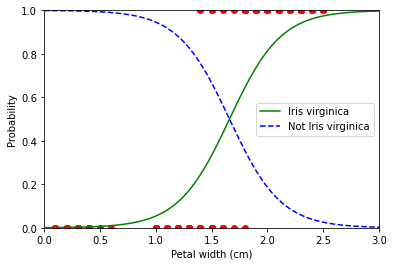

In [190]:
#Look at the model's estimated p for flowers with varying petal widths (0-3cm)

X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], 'g-', label='Iris virginica')
plt.plot(X_new, y_proba[:, 0], 'b--', label='Not Iris virginica')
plt.scatter(X, y, c='r')
plt.xlabel('Petal width (cm)'); plt.ylabel('Probability')
plt.axis([0,3,0,1])
plt.legend()

In [155]:
y_proba

array([[9.99250016e-01, 7.49984089e-04],
       [9.99240201e-01, 7.59799387e-04],
       [9.99230257e-01, 7.69743043e-04],
       ...,
       [3.08374822e-03, 9.96916252e-01],
       [3.04400296e-03, 9.96955997e-01],
       [3.00476842e-03, 9.96995232e-01]])

In [191]:
log_reg.predict([[1.7], [1.5]]) #Decision boundary at around 1.6cm, where both probabilites are 50%

array([1, 0])

In [192]:
#N.B. Just like the other linear models, Logistic Regression models can be regularized using ℓ1 or ℓ2 penalties. 
#Scikit-Learn actually adds an ℓ2 penalty by default. The hyperparameter controlling the regularization strength of a
#Scikit-Learn LogisticRegression model is not alpha (as in other linear models), but its inverse: C. The higher the value 
#of C, the less the model is regularized.

In [193]:
#Softmax Regression - allows Logistic Regression to be generalized to support multiple classes directly. When given an 
#instance x, the Softmax model first computes a score s_k(x) for each class k, then estimates the probability of each class
#by appluing the softmax function (the normalized exponential) to the scores. The scores s_k(x) = xT*theta^(k), where each
#class has a dedicated parameter vector theta^(k). These vectors are typically stored as rows in a parameter matrix. Once
#the score of every class is calculated, the probability the instance belongs to class k is given by the normalized
#exponential of the score s_k(x), where the normalization is over all classes K - the Softmax classifier then predicts
#the class with the highest estimated probability, which is simply the class with the highest score s_k(x).
#N.B. the Softmax Regression classifier predicts only one class at a time (i.e. it is multiclass, not multioutput), so
#it should only be used with mutually exclusive classes, such as different types of plants - it cannot be used to recognise
#multiple people in one picture, for example.

In [199]:
#The cross entropy cost function is used in training as it penalizes the model when it estimates a low probability for the
#target class. Cross entropy is frequently used to measure how well a set of estimated class probabilities matches the 
#target classes. The form of the cross entropy equation reduces to the log loss cost function of Logistic Regression 
#when there are just two classes (K = 2). 
#We can use GD (or any other optimization algorithm) to find the parameter matrix that minimizes the cost function.

#Let’s use Softmax Regression to classify the iris flowers into all three classes - sklearn's LogisticRegression uses 
#one-versus-the-rest (OvR) by default when you train it on more than two classes, but you can set the multi_class 
#hyperparameter to "multinomial" to switch it to Softmax Regression. You must also specify a solver that supports 
#Softmax Regression, such as the "lbfgs" solver (a type of optimization algorithm, see docs). It also applies ℓ2 
#regularization by default, which you can control using the hyperparameter C:

X = iris['data'][:, (2,3)] #petal length, petal width
y = iris['target']

softmax_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=10)
softmax_reg.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [203]:
#N.B. the model can predict a class that has a probability below 50% - e.g. at the point in feature space where all 
#decision boundaries meet and all classes have equal estimated probability of 33%. Also note that the decision boundaries
#between any two classes are linear.
softmax_reg.predict([[2.6,3.1]]), softmax_reg.predict_proba([[2.6,3.1]])

(array([1]), array([[0.33299228, 0.37074148, 0.29626624]]))